In [ ]:
"""
input:
    - correlation_df_VaccinationPercentage_ATV.parquet
    - date_based_covid_data_ATV_and_unemployment.parquet
output:
    - correlation_VaccinationPercentage_ATV.svg
    - MannWhitneyU_VaccinationPercentage_ATV.pdf
"""

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

from src.scripts.common_figures import Figures

In [4]:
supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

figures = Figures()

### ATV vs Vaccination Percentage

In [ ]:
vaccination_percentage = pd.read_parquet(f"{dataframes_path}/correlation_df_VaccinationPercentage_ATV.parquet")

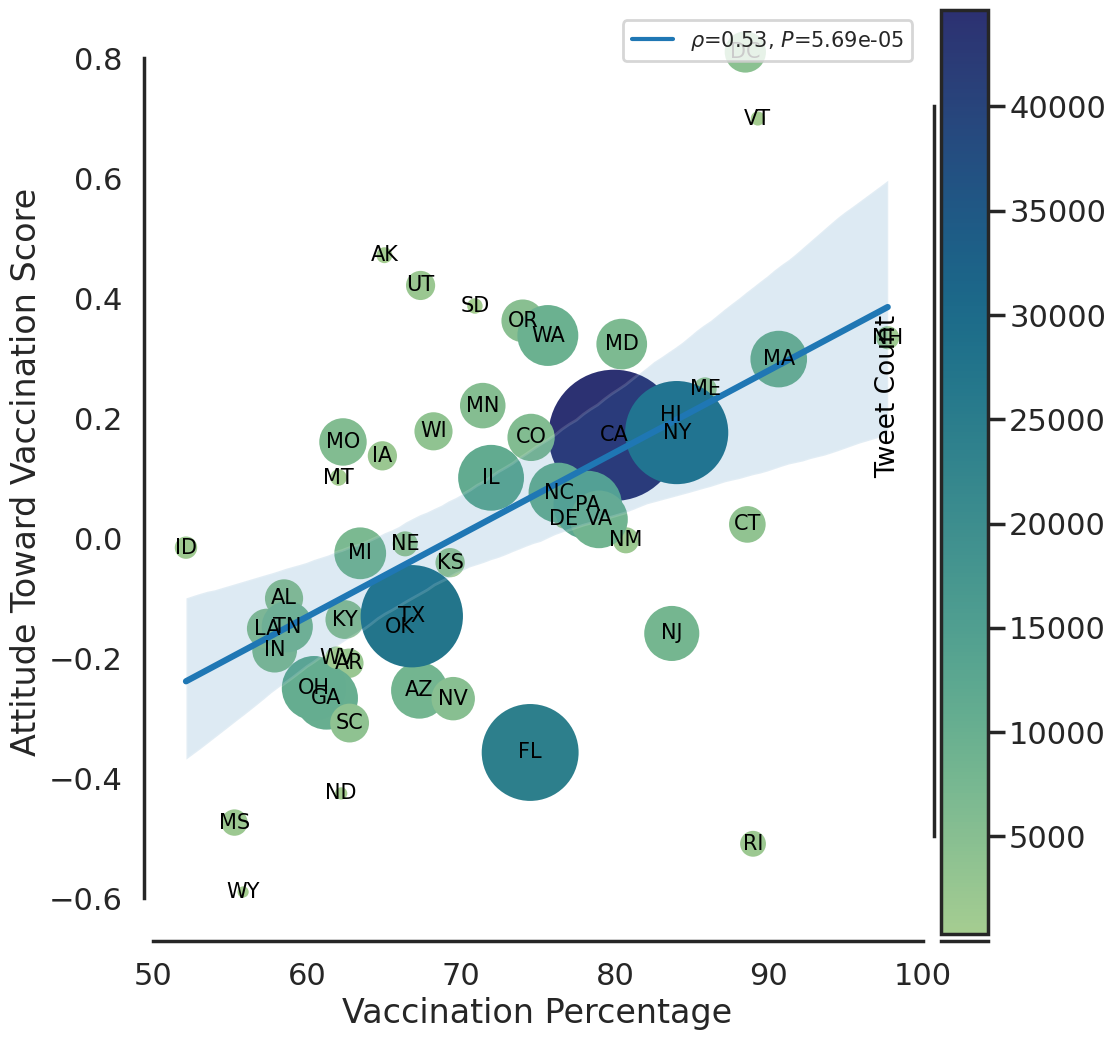

In [7]:
paper_figure = f"{supp_figures_path}/correlation_VaccinationPercentage_ATV.svg"

figures.draw_correlation_figure(vaccination_percentage, 'vaccination_percentage', 'odd_ratios',
                                'Vaccination Percentage', 'Attitude Toward Vaccination Score', figsize=(12, 12),
                                point_size_multiplexer=0.2, save=None, paper_figure=paper_figure)

# Mann-Whitney U Test

In [8]:
covid_data = pd.read_parquet(f"{dataframes_path}/date_based_covid_data_ATV_and_unemployment.parquet")
covid_data['date'] = pd.to_datetime(covid_data['date'])

In [9]:
dates = ['2021-01-01', '2021-03-01', '2021-06-01', '2021-09-01', '2021-12-31']
dates_and_thresholds = covid_data[covid_data['date'].isin(pd.to_datetime(pd.Series(dates)))][['date', 'people_vaccinated_per_hundred']]
dates_and_thresholds

,date,people_vaccinated_per_hundred
366,2021-01-01,0.0168
425,2021-03-01,0.1727
517,2021-06-01,0.5249
609,2021-09-01,0.6243
730,2021-12-31,0.7373


In [ ]:
# date based threshold

vp_and_si = covid_data[['people_vaccinated_per_hundred', 'odd_ratios']]
vp_and_si['people_vaccinated_per_hundred'] = vp_and_si['people_vaccinated_per_hundred'] * 100
thresholds = dates_and_thresholds['people_vaccinated_per_hundred'].values * 100
for idx, threshold in enumerate(thresholds):
    if idx == 0:
        filter_ = (vp_and_si['people_vaccinated_per_hundred'] <= threshold)
        x_label = f'2020-01-01 -\n{dates[0]}'
    else:
        filter_ = ((vp_and_si['people_vaccinated_per_hundred'] <= threshold) & (vp_and_si['people_vaccinated_per_hundred'] > thresholds[idx-1]))
        x_label = f'{str(dates[idx-1])} -\n{str(dates[idx])}'
    vp_and_si.loc[filter_, 'threshold'] = [x_label] * filter_.sum()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2020-01-01 -
2021-01-01 v.s. 2021-01-01 -
2021-03-01: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.304e-31 U_stat=5.590e+02
2020-01-01 -
2021-01-01 v.s. 2021-03-01 -
2021-06-01: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.675e-42 U_stat=1.261e+03
2020-01-01 -
2021-01-01 v.s. 2021-06-01 -
2021-09-01: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.135e-23 U_stat=5.317e+03
2020-01-01 -
2021-01-01 v.s. 2021-09-01 -
2021-12-31: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.996e-04 U_stat=1.710e+04


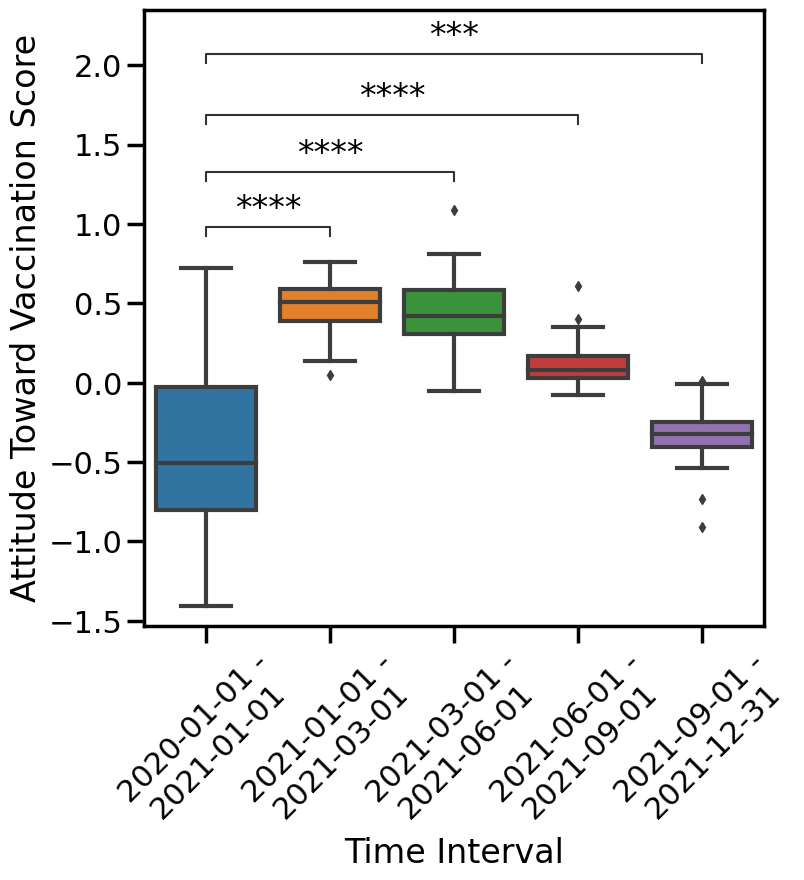

In [12]:
list_of_thresholds = list(vp_and_si['threshold'].unique())

plt.figure(figsize=(8, 8))
sns.reset_orig()
sns.set_context('poster', font_scale=1)
ax = sns.boxplot(data=vp_and_si, x='threshold', y='odd_ratios')
add_stat_annotation(ax, data=vp_and_si,  x='threshold', y='odd_ratios',
                    box_pairs=[(list_of_thresholds[0], i) for i in list_of_thresholds[1:]],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.xlabel('Time Interval')
plt.ylabel('Attitude Toward Vaccination Score')
plt.xticks(rotation=45)
plt.savefig(f'{supp_figures_path}/MannWhitneyU_VaccinationPercentage_ATV.pdf', bbox_inches='tight')